## 1. Data loading & preprocessing

Try following data preprocessing and augmentation:
- RandomResizedCrop: useful
- RandomHorizontalFlip: useful
- RandomRotation: negtive effects
- RandomVerticalFlip: negtive effects
- Normalize: unuseful

In [2]:
import csv
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# data preprocessing and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((32,32)),
#     transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])


# define dataset
class CIFAR10Dataset(Dataset):
    """`CIFAR10 Dataset.

    Args:
        data_list (list[str]): The images files paths of the CIFAR10 Dataset.
        label_path (str): The path of label file.
        transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed version.
    """
    def __init__(self, data_list, label_path, transform=None):
        self.data_list = data_list
        self.label_dict = self._csv2dict(label_path)
        self.transform = transform
        if self.transform is None:
            self.transform = transforms.ToTensor()

    def _csv2dict(self, label_path):
        """Load labels from csv file"""
        label_dict = {}
        with open(label_path, mode='r', encoding='utf-8') as csv_file:
            reader = csv.DictReader(csv_file)
            for row in reader:
                label_dict[f'image_{row["id"]}.png'] = int(row['label']) 
        return label_dict

    def __len__(self):
        return len(self.data_list)
     
    def __getitem__(self, idx):
        img_path = self.data_list[idx]
        img = Image.open(img_path)
        img = img.convert("RGB")
        img_transformed = self.transform(img)
        label = self.label_dict[img_path.split('/')[-1]]
        return img_transformed, label

class TestDataset(CIFAR10Dataset):
    """`CIFAR10 test Dataset.

    Args:
        data_list (list[str]): The images files paths of the CIFAR10 Dataset.
        transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed version.
    """
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        if self.transform is None:
            self.transform = transforms.ToTensor()

    def __getitem__(self, idx):
        img_path = self.data_list[idx]
        img = Image.open(img_path)
        img = img.convert("RGB")
        img_transformed = self.transform(img)
        id = img_path.split('_')[-1][:-4]
        return img_transformed, id


# dataset root
data_root = 'cifar10_images/train'
test_data_root = 'cifar10_images/test'
label_path = 'train.csv'

# read data path list
data_list = ['/'.join([data_root, i]) for i in os.listdir(data_root)]
test_list = ['/'.join([test_data_root, i]) for i in os.listdir(test_data_root)]
train_list, val_list = train_test_split(data_list, test_size=0.2,random_state=101)
print(f'train dataset size: {len(train_list)}, validation dataset size: {len(val_list)}, test datasetsize: {len(test_list)}')

# build train, validation and test dataset
train_dataset = CIFAR10Dataset(train_list, label_path, train_transforms)
val_dataset = CIFAR10Dataset(val_list, label_path, val_transforms)
test_dataset = TestDataset(test_list, test_transforms)

train dataset size: 40000, validation dataset size: 10000, test datasetsize: 5000


## 2. Define the model

### Resnet
- Classic CNN network.
- Very easy to achieve 90%+ score on this dataset.

In [3]:
import torch.nn as nn

class BasicBlock(nn.Module):
    """Basic Block for Resnet18 and Resnet34.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int): Stride of the first conv module, default to 1.
    """

    expansion = 1 # distinct BasicBlock and BottleNeck

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 stride: int = 1):
        super().__init__()

        # residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        # shortcut
        self.shortcut = nn.Sequential()
        # when output dimension != input dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        output = self.residual_function(x)
        output += self.shortcut(x)
        return nn.ReLU(inplace=True)(output)


class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int): Stride of the first conv module, default to 1.
    """

    expansion = 4 # distinct BasicBlock and BottleNeck

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 stride: int = 1):
        super().__init__()

        # residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        # shortcut
        self.shortcut = nn.Sequential()
        # when output dimension != input dimension
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        output = self.residual_function(x)
        output += self.shortcut(x)
        return nn.ReLU(inplace=True)(output)


class ResNet(nn.Module):
    """General ResNet.

    Args:
        block (str): Type of residul block
        num_block (list[int]): Depth of every stage.
        num_classes (int): Determine the output dimension, default to 10.
    """

    def __init__(self,
                 block: str,
                 num_block: list,
                 num_classes: int = 10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.layer1 = self._make_layer(block, 64, num_block[0], 1)
        self.layer2 = self._make_layer(block, 128, num_block[1], 2)
        self.layer3 = self._make_layer(block, 256, num_block[2], 2)
        self.layer4 = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

# different scale of ResNet
def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

### ViT
- Use transformer framework on vision tasks
- Training more slowly than ResNet
- Hard to tune hyper-parameters
- Because not allowed to use extra dataset and pre-trained model, it's hard to achieve high performance.

In [4]:
import torch
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

""""
Reference: https://github.com/lucidrains/vit-pytorch
"""

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

## 3. Train & Test pipeline

Unified pipelines to train model and test on test dataset.

### train pipeline

In [5]:
import os
import time
import torch
def train(model,
          train_dataset,
          val_dataset,
          batch_size,
          epoch,
          loss_function,
          optimizer,
          output_root = './outputs',
          save_epoch = 1,
          resume = None,
          start_epoch = 1,
          device = 'cuda:0'
    ):

    model = model.to(device)

    # resume
    if resume:
        model.load_state_dict(torch.load(resume))
        model.to(device)

    # make save path
    current_time = time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())
    output_path = os.path.join(output_root, current_time)
    os.makedirs(output_path, exist_ok=True)

    # build dataloader
    train_dataloader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True )
    val_dataloader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True)

    # used for logging
    iter_num =  int(len(train_dataset) / train_dataloader.batch_size)
    best_acc = 0
    f_log = open(os.path.join(output_path, 'log.log'), 'w', encoding='utf-8')
    f_loss_acc = open(os.path.join(output_path, 'loss.log'), 'w', encoding='utf-8')

    for e in range(start_epoch, epoch+1):
        train_loss = 0
        train_accuracy = 0
        
        for idx, (data, label) in enumerate(train_dataloader):
            data, label = data.to(device), label.to(device)

            outputs = model(data)
            loss = loss_function(outputs, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute accurency and loss
            acc = (outputs.argmax(dim=1) == label).float().mean()
            train_accuracy += acc / len(train_dataloader)
            train_loss += loss / len(train_dataloader)

            # logging
            if idx % 100 == 0:
                print(f'Epoch:{e}/{epoch}, iter:{idx}/{iter_num}, loss:{loss.item():.4f}')
                f_log.write(f'Epoch:{e}/{epoch}, iter:{idx}/{iter_num}, loss:{loss.item():.4f}\n')

            f_loss_acc.write(f'{loss.item():.4f}\n')

        # validation of each epoch
        label_list = []
        prediction_list = []
        with torch.no_grad():
            val_accuracy = 0
            val_loss = 0
            for idx, (data, label) in enumerate(val_dataloader):
                data = data.to(device)
                label = label.to(device)

                outputs = model(data)
                loss = loss_function(outputs, label)
                acc = (outputs.argmax(dim=1) == label).float().mean()
                val_accuracy += acc / len(val_dataloader)
                val_loss += loss / len(val_dataloader)

                label_list += label.tolist()
                prediction_list += outputs.argmax(dim=1).tolist()

        print(f'Epoch:{e}/{epoch}, train_loss:{train_loss:.4f}, train_accuracy:{train_accuracy:.4f}, val_loss:{val_loss:.4f}, val_accuracy:{val_accuracy:.4f}')
        f_log.write(f'Epoch:{e}/{epoch}, train_loss:{train_loss:.4f}, train_accuracy:{train_accuracy:.4f}, val_loss:{val_loss:.4f}, val_accuracy:{val_accuracy:.4f}\n')
        
        # model saving
        if best_acc < val_accuracy:
            model_name = f'best_epoch_{e}_{val_accuracy:.4f}.pth'
            save_path = os.path.join(output_path, model_name)
            print(f'saving best model to {save_path}')
            torch.save(model.state_dict(), save_path)
            best_acc = val_accuracy
            continue

        if epoch % save_epoch == 0:
            model_name = f'epoch_{e}_{val_accuracy:.4f}.pth'
            save_path = os.path.join(output_path, model_name)
            print(f'saving model to {save_path}')
            torch.save(model.state_dict(), save_path)
    
    
    f_loss_acc.close()
    f_log.close()


### test pipeline

In [6]:
def test(model,
         checkpoint_path,
         test_dataset,
         batch_size,
         result_path = 'submission.csv',
         device = 'cuda:0',
    ):

    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    test_dataloader = DataLoader(dataset = test_dataset, batch_size=batch_size)
    
    current_time = time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())
    output_path = os.path.join('./submissions', current_time)
    os.makedirs(output_path, exist_ok=True)
    f = open(os.path.join(output_path, result_path), 'w', encoding='utf-8')
    f.write('id,label\n')

    with torch.no_grad():
        for data, ids in test_dataloader:
            data = data.to(device)

            outputs = model(data)
            labels = outputs.argmax(dim=1)
            for i in range(len(ids)):
                f.write(f'{ids[i]},{labels[i]}\n')
    f.close()

## 4. Train model

### Train ResNet

Select best framework: find that larger framework is not useful.
| Model | Accuracy on validation |
| ---- | ---- |
| Resnet18 | 0.9080 |
| Resnet34 | 0.9131 |
| Resnet50 | 0.9094 |
| Resnet101 | 0.9067 |
| Resnet152 | 0.9080 | 

Tuning hyper-parameters：
- there is very small difference between different optimize and scheduler
- Adam and StepLR is better
- larger learning rate is batter (1e-3 > 1e-4)

In [7]:
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingLR
import torch.optim as optim

# build models
# model = resnet18()
model = resnet34()
# model = resnet50()
# model = resnet101()
# model = resnet152()

# loss function
loss_function = nn.CrossEntropyLoss()

# select optimizer
lr = 1e-4
momnetum = 0.9
weught_decay = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momnetum, weight_decay=weught_decay)

# scheduler
gamma = 0.1
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
# scheduler = MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
# secheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

train(model=model,
      train_dataset=train_dataset,
      val_dataset=val_dataset,
      epoch=100,
      batch_size=32,
      loss_function=loss_function,
      optimizer=optimizer,
#       resume='',
#       start_epoch=21,
)

Epoch:1/1, iter:0/1250, loss:2.4767
Epoch:1/1, iter:100/1250, loss:1.8784
Epoch:1/1, iter:200/1250, loss:2.0675
Epoch:1/1, iter:300/1250, loss:2.1030
Epoch:1/1, iter:400/1250, loss:2.0819
Epoch:1/1, iter:500/1250, loss:1.4159
Epoch:1/1, iter:600/1250, loss:2.0422
Epoch:1/1, iter:700/1250, loss:1.6316
Epoch:1/1, iter:800/1250, loss:1.7678
Epoch:1/1, iter:900/1250, loss:1.6053
Epoch:1/1, iter:1000/1250, loss:1.6119
Epoch:1/1, iter:1100/1250, loss:1.7114
Epoch:1/1, iter:1200/1250, loss:1.8297
Epoch:1/1, train_loss:1.7927, train_accuracy:0.3422, val_loss:1.4304, val_accuracy:0.4867
saving best model to ./outputs\2024_08_05_00_22_12\best_epoch_1_0.4867.pth


### Train ViT
- Adam and MultiStepLR are better.
- Because of slow convergence speed, MultiStepLr can set a large learning rate in the beginning to accelarate training.

In [8]:
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingLR
import torch.optim as optim

# build models
model = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 64,
    depth = 6,
    heads= 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1, 
)

# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer
lr = 1e-3
weight_decay = 5e-5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# scheduler
gamma = 0.1
# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
scheduler = MultiStepLR(optimizer, milestones=[100, 200], gamma=0.1)
# scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-5)

train(model=model,
      train_dataset=train_dataset,
      val_dataset=val_dataset,
      epoch=300,
      batch_size=32,
      loss_function=loss_function,
      optimizer=optimizer,
#       resume='',
#       start_epoch=21,
)

Epoch:1/1, iter:0/1250, loss:2.2614
Epoch:1/1, iter:100/1250, loss:1.9547
Epoch:1/1, iter:200/1250, loss:2.1520
Epoch:1/1, iter:300/1250, loss:1.8578
Epoch:1/1, iter:400/1250, loss:1.7152
Epoch:1/1, iter:500/1250, loss:1.8707
Epoch:1/1, iter:600/1250, loss:1.9102
Epoch:1/1, iter:700/1250, loss:2.0646
Epoch:1/1, iter:800/1250, loss:1.8140
Epoch:1/1, iter:900/1250, loss:1.7710
Epoch:1/1, iter:1000/1250, loss:1.7542
Epoch:1/1, iter:1100/1250, loss:1.7027
Epoch:1/1, iter:1200/1250, loss:1.9466
Epoch:1/1, train_loss:1.9050, train_accuracy:0.2865, val_loss:1.7359, val_accuracy:0.3756
saving best model to ./outputs\2024_08_05_00_30_22\best_epoch_1_0.3756.pth


## 5. Evalution

Except compare accurancy, we have many other metrics.

- TP: true positive
- FP: false positive
- TN: true negtive
- FN: false negtive
- Precision = tp / (tp + fp)
- Recall = tp / (tp + fn)
- F1 score = 2 * Precision * Recall / (Precision + Recall)

Compute these metrics for every class and compare ResNet and ViT.

Draw comfusion matrix and ROC curve.
 

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import numpy as np

# use sklearn.metrics.confusion_matrix to get confusion matrix
def getConfusionMatrix(label_list, prediction_list):
        cm = confusion_matrix(label_list, prediction_list, labels=range(10), normalize=None)
        # Create the list of unique labels in the test set, to use in our plot
        x = y = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        # Plot the matrix above as a heatmap with annotations (values) in its cells
        fig = ff.create_annotated_heatmap(cm, x, y)
        # Set titles and ordering
        fig.update_layout( title_text="<b>Confusion matrix</b>", yaxis = dict(categoryorder = "category descending"))
        fig.add_annotation(dict(font=dict(color="black",size=14),
                                x=0.5,
                                y=-0.15,
                                showarrow=False,
                                text="Predicted label",
                                xref="paper",
                                yref="paper"))
        fig.add_annotation(dict(font=dict(color="black",size=14),
                                x=-0.15,
                                y=0.5,
                                showarrow=False,
                                text="Actual label",
                                textangle=-90,
                                xref="paper",
                                yref="paper"))
        # We need margins so the titles fit
        fig.update_layout(margin=dict(t=80, r=20, l=100, b=50))
        fig['data'][0]['showscale'] = True
        fig.show()

        return cm


# use sklearn.metrics.roc_curve to get roc curve
def getRocAuc(y_true, y_scores):
    y_one_hot = label_binarize(y_true, classes=np.arange(10))
    fpr, tpr, threshold = roc_curve(y_one_hot.ravel(), y_scores.ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

def drawMetrics(precisions, recalls, f1s, classes):
    plt.figure(figsize=(20,10))
    plt.xlabel('class', fontsize=14)
    plt.ylabel('score', fontsize=14)
    plt.grid(linestyle=':', axis='y')
    x = np.arange(10)
    a = plt.bar(x - 0.3, precisions, 0.3, color='dodgerblue', label='Precision', align='center')
    b = plt.bar(x, recalls, 0.3, color='orangered', label='Recall', align='center')
    c = plt.bar(x + 0.3, f1s, 0.3, color='limegreen', label='F1', align='center')
    for i in a + b + c:
        h = i.get_height()
        plt.text(i.get_x() + i.get_width() / 2, h, '%.4f' % h, ha='center', va='bottom')
    plt.xticks(x, classes,rotation=75)
    plt.legend(loc='lower right')
    plt.show()

def evaluate(model,
         checkpoint_path,
         val_dataset,
         batch_size,
         device = 'cuda:0',
    ):

    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    val_dataloader = DataLoader(dataset = val_dataset, batch_size=batch_size)

    label_list = []
    prediction_list = []
    with torch.no_grad():
        val_accuracy = 0
        for idx, (data, label) in enumerate(val_dataloader):
            data = data.to(device)
            label = label.to(device)

            outputs = model(data)
            acc = (outputs.argmax(dim=1) == label).float().mean()
            val_accuracy += acc / len(val_dataloader)

            label_list += label.tolist()
            prediction_list += outputs.argmax(dim=1).tolist()
            if idx == 0:
                prediction_scores  = outputs.cpu().numpy()
            else:
                prediction_scores = np.concatenate((prediction_scores , outputs.cpu().numpy()), axis=0)
    
        auc = getRocAuc(label_list, prediction_scores)
        cm = getConfusionMatrix(label_list, prediction_list)

        classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        results = {}
        precisions = []
        recalls = []
        f1s = []
        # calculate metrics for each class
        for i in range(len(classes)):
            tp = cm[i][i]
            fp = sum(cm[:, i]) - tp
            fn = sum(cm[i, :]) - tp
            tn = sum(sum(cm)) - tp - fp - fn
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * precision * recall / (precision + recall)
            results[classes[i]] = {'precision': precision, 'recall': recall, 'f1': f1}
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

        drawMetrics(precisions, recalls, f1s, classes)
        
        return results, val_accuracy, auc



### Evaluate ResNet

<Figure size 640x480 with 0 Axes>

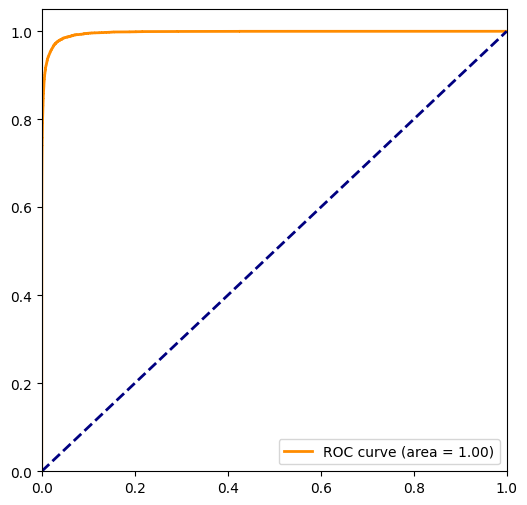

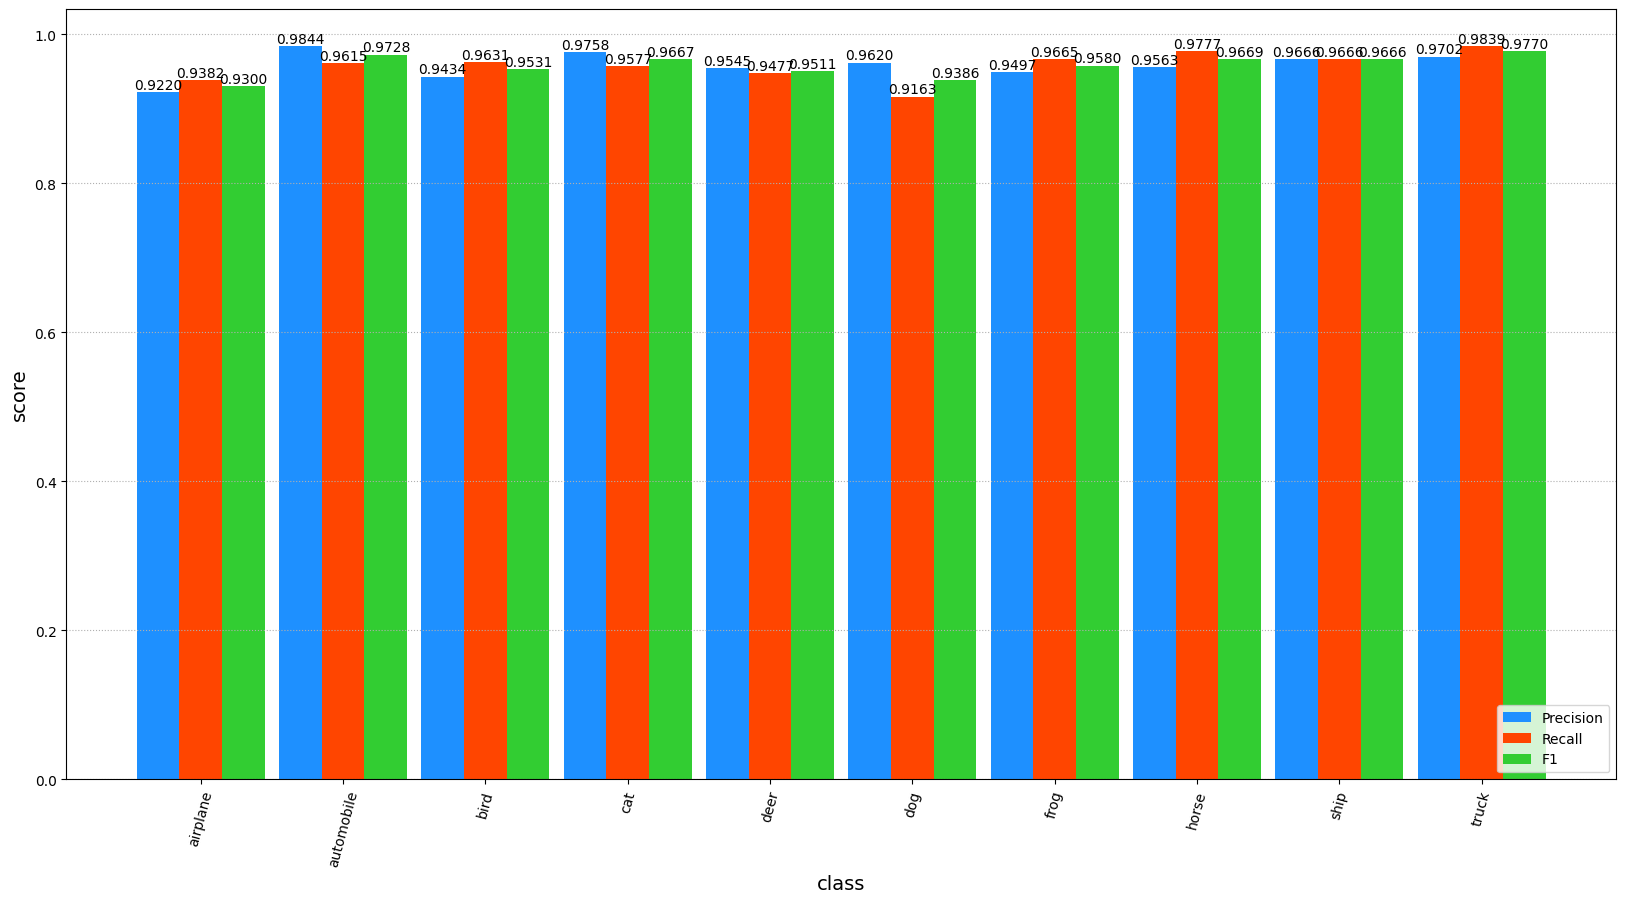

ResNet:
Accuracy: 0.9582
AUC: 0.9964
{'airplane': {'precision': 0.9219653179190751, 'recall': 0.9382352941176471, 'f1': 0.9300291545189505}, 'automobile': {'precision': 0.9844398340248963, 'recall': 0.961499493414387, 'f1': 0.972834443874936}, 'bird': {'precision': 0.943359375, 'recall': 0.963110667996012, 'f1': 0.9531327084361124}, 'cat': {'precision': 0.9758403361344538, 'recall': 0.9577319587628866, 'f1': 0.9667013527575442}, 'deer': {'precision': 0.9544534412955465, 'recall': 0.9477386934673366, 'f1': 0.9510842158345941}, 'dog': {'precision': 0.9620390455531453, 'recall': 0.9163223140495868, 'f1': 0.9386243386243387}, 'frog': {'precision': 0.9497098646034816, 'recall': 0.9665354330708661, 'f1': 0.9580487804878048}, 'horse': {'precision': 0.956315289648623, 'recall': 0.9776699029126213, 'f1': 0.9668746999519924}, 'ship': {'precision': 0.9665683382497542, 'recall': 0.9665683382497542, 'f1': 0.9665683382497542}, 'truck': {'precision': 0.9702380952380952, 'recall': 0.9839034205231388, 

In [15]:
model_resnet = resnet34()

results_resnet, acc_resnet, auc_resnet = evaluate(model=model_resnet,
        checkpoint_path='./best_epoch_98_0.9131.pth',
        val_dataset=val_dataset,
        batch_size=32
)

print("ResNet:")
print(f"Accuracy: {acc_resnet:.4f}")
print(f"AUC: {auc_resnet:.4f}")
print(results_resnet)

### Evaluate ViT

<Figure size 640x480 with 0 Axes>

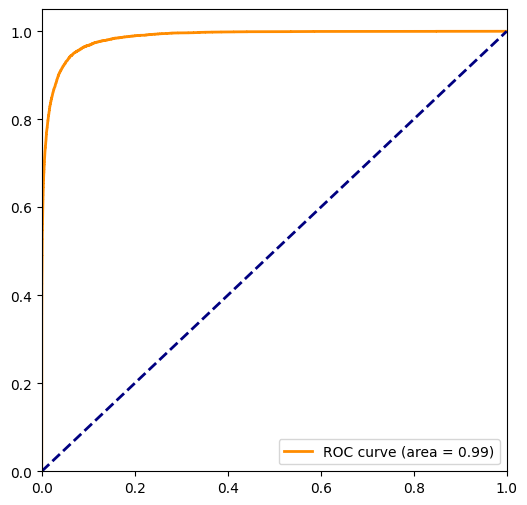

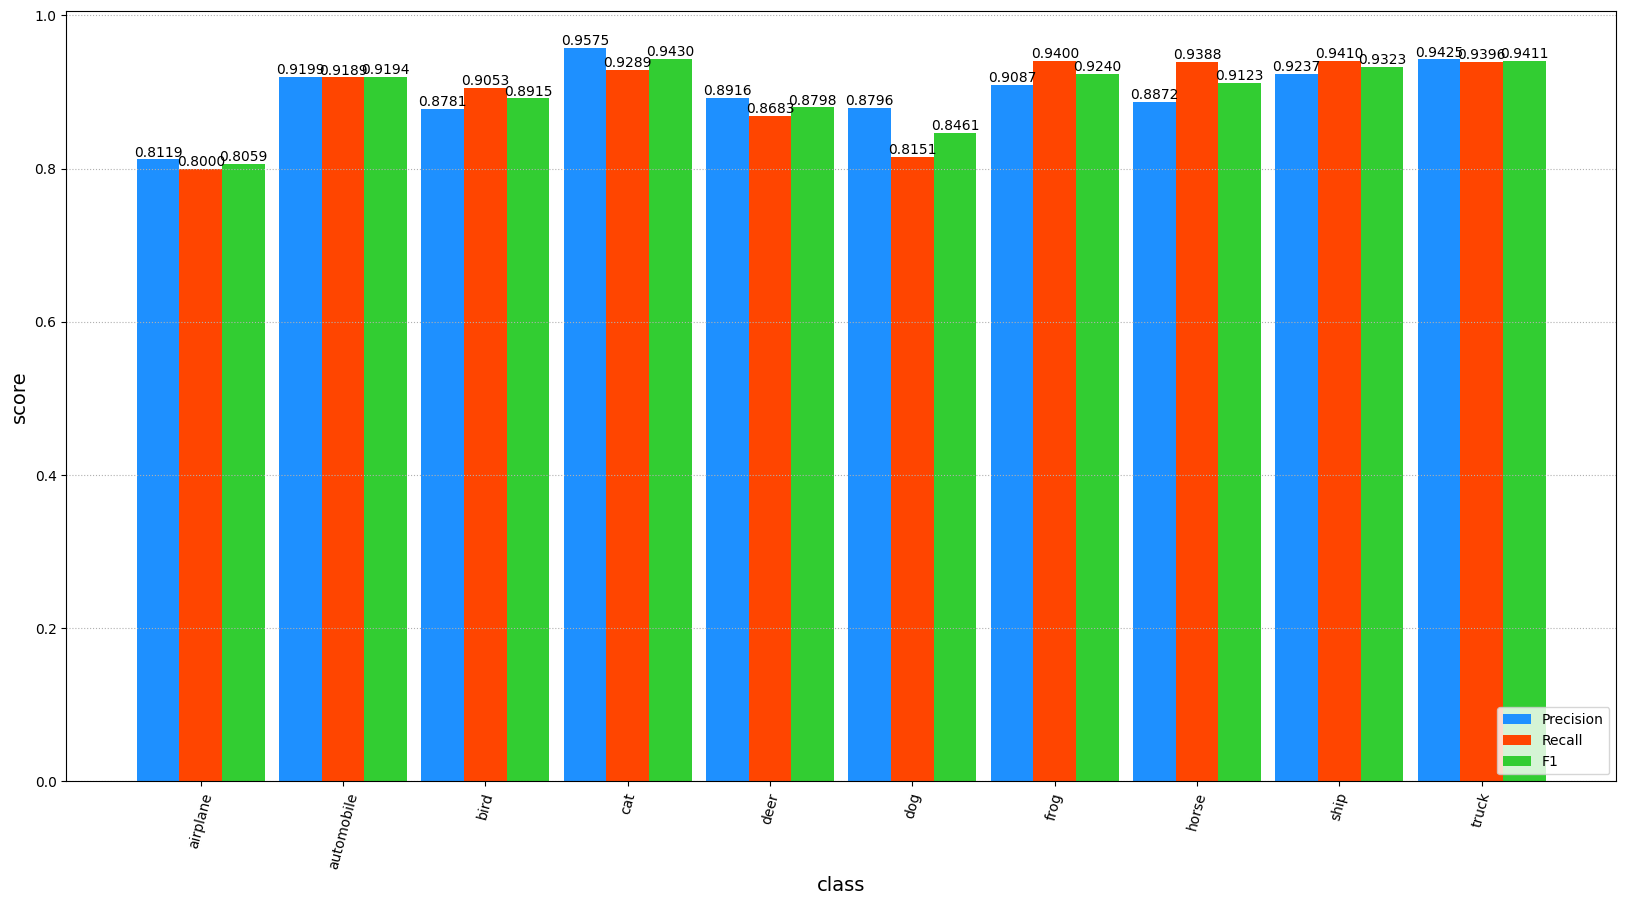

ViT:
Accuracy: 0.8997
AUC: 0.9860
{'airplane': {'precision': 0.8119402985074626, 'recall': 0.8, 'f1': 0.8059259259259259}, 'automobile': {'precision': 0.9198782961460447, 'recall': 0.9189463019250254, 'f1': 0.9194120628484541}, 'bird': {'precision': 0.8781431334622823, 'recall': 0.905284147557328, 'f1': 0.891507118311242}, 'cat': {'precision': 0.9574920297555791, 'recall': 0.9288659793814433, 'f1': 0.9429618001046572}, 'deer': {'precision': 0.891640866873065, 'recall': 0.8683417085427135, 'f1': 0.879837067209776}, 'dog': {'precision': 0.8795986622073578, 'recall': 0.8150826446280992, 'f1': 0.846112600536193}, 'frog': {'precision': 0.9086584205518554, 'recall': 0.9399606299212598, 'f1': 0.9240445089501693}, 'horse': {'precision': 0.8871559633027523, 'recall': 0.9388349514563107, 'f1': 0.9122641509433962}, 'ship': {'precision': 0.9237451737451737, 'recall': 0.9410029498525073, 'f1': 0.9322942036044812}, 'truck': {'precision': 0.9424823410696267, 'recall': 0.9396378269617707, 'f1': 0.9410

In [17]:
model_vit = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 64,
    depth = 6,
    heads= 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1, 
)


results_resnet, acc_resnet, auc_resnet = evaluate(model=model_vit,
        checkpoint_path='./best_epoch_382_0.8149.pth',
        val_dataset=val_dataset,
        batch_size=32
)

print("ViT:")
print(f"Accuracy: {acc_resnet:.4f}")
print(f"AUC: {auc_resnet:.4f}")
print(results_resnet)

- Accuracy and AUC of Resnet are higher than ViT.
- Both of models are more likely to confuse airplane and dog.

## 6. Ensemble Learning
- Using Ensemble Learning method, use Resnet and ViT vote for the pridiction result.
- Weights of them is Resnet:ViT = 3:1.
- This method can improve accuracy.

In [18]:
def EnsembleLearning(model1,
         checkpoint_path1,
         model2,
         checkpoint_path2,
         test_dataset,
         batch_size,
         result_path = 'submission.csv',
         device = 'cuda:0',
    ):

    model1.load_state_dict(torch.load(checkpoint_path1))
    model1.to(device)
    model2.load_state_dict(torch.load(checkpoint_path2))
    model2.to(device)
    test_dataloader = DataLoader(dataset = test_dataset, batch_size=batch_size)
    
    current_time = time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())
    output_path = os.path.join('./submissions', current_time)
    os.makedirs(output_path, exist_ok=True)
    f = open(os.path.join(output_path, result_path), 'w', encoding='utf-8')
    f.write('id,label\n')

    with torch.no_grad():
        for data, ids in test_dataloader:
            data = data.to(device)
            outputs = 3*model1(data) + model2(data) 
            labels = outputs.argmax(dim=1)
            for i in range(len(ids)):
                f.write(f'{ids[i]},{labels[i]}\n')
    f.close()

model1 = resnet34()
model2 = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 64,
    depth = 6,
    heads= 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1, 
)

EnsembleLearning(model1=model1,
     checkpoint_path1='./best_epoch_98_0.9131.pth',
     model2=model2,
     checkpoint_path2='./best_epoch_382_0.8149.pth',
     test_dataset=test_dataset,
     batch_size=32
)   

## 7. Summary
### 1. Data preprocessing & augmentation
- RandomResizedCrop: and RandomHorizontalFlip are useful.
- RandomRotation, RandomVerticalFlip and Normalizea are unuseful.

### 2.Define the model
- ResNet
  - Classic CNN network.
  - Very easy to achieve 90%+ score on this dataset.
- ViT
  - Use transformer framework on vision tasks.
  - Training more slowly than ResNet.

### 3. Pipelines
- Design unified pipelines to train model and test on test dataset.

### 4. Train model
- ResNet
  - larger framework is not useful.
  - Adam and StepLR is better.
  - larger learning rate is batter (1e-3 > 1e-4).
- ViT
  - Because of slow convergence speed, MultiStepLr can set a large learning rate in the beginning to accelarate training.
  
### 5. Evaluation
  - Compare ResNet and ViT with following metrics:
    - Precision
    - Recall
    - F1 score
    - Overall Accuracy
    - ROC curve
    - AUC
    - Confusion matrix
- Accuracy and AUC of Resnet are higher than ViT.
- Both of models are more likely to confuse airplane and dog.

### Ensemble Learning
- Using Ensemble Learning method, use Resnet and ViT vote for the pridiction result.
- Weights of them is Resnet:ViT = 3:1.